In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

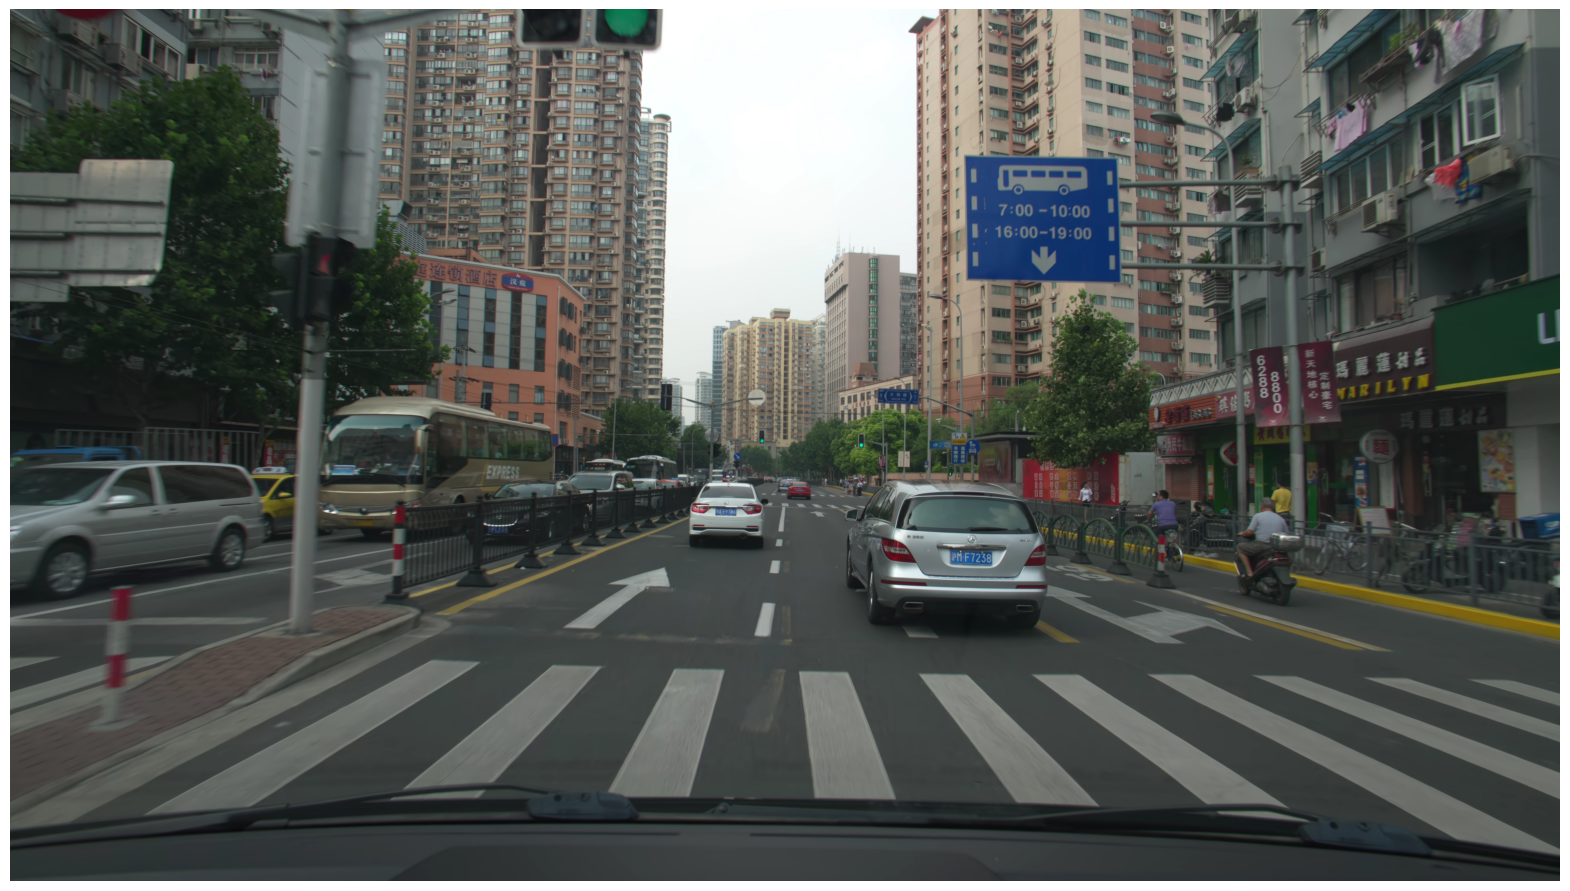

In [2]:
image = cv2.imread('../rgb_images/048.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [4]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam, points_per_side=32, box_nms_thresh = 0.7)

In [16]:
masks = mask_generator.generate(image)

In [23]:
print(len(masks))
print(masks[0].keys())
#filter out masks with area less than 100000
masks = [mask for mask in masks if mask['area'] > 100000]
print(len(masks))

85
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
18


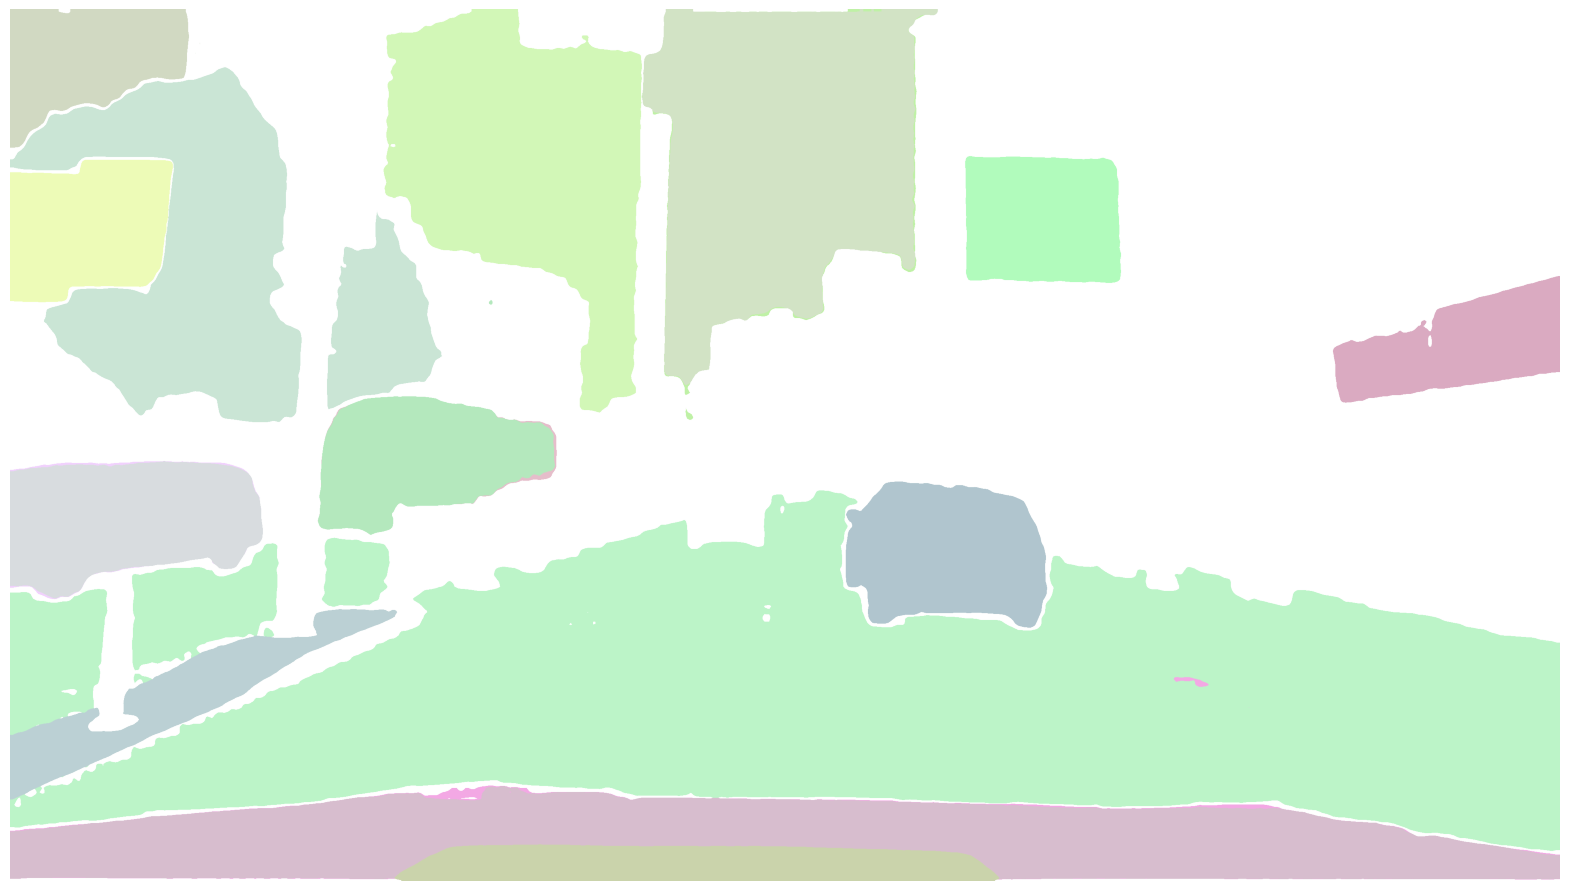

In [24]:
plt.figure(figsize=(20,20))
plt.imshow(image, alpha=0)
show_anns(masks)
plt.axis('off')
plt.show() 

In [131]:
item_num = 23 #item_num為辨別出來之物體的編號（0=<item_num<(len(mask)))
print(masks[item_num])

{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 137313, 'bbox': [763, 647, 585, 662], 'predicted_iou': 0.9191157817840576, 'point_coords': [[780.0, 1248.75]], 'stability_score': 0.9575817584991455, 'crop_box': [0, 0, 3840, 2160]}


24
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 116244, 'bbox': [2366, 364, 386, 314], 'predicted_iou': 1.0117173194885254, 'point_coords': [[2580.0, 573.75]], 'stability_score': 0.9806511998176575, 'crop_box': [0, 0, 3840, 2160]}
2366 364 386 314


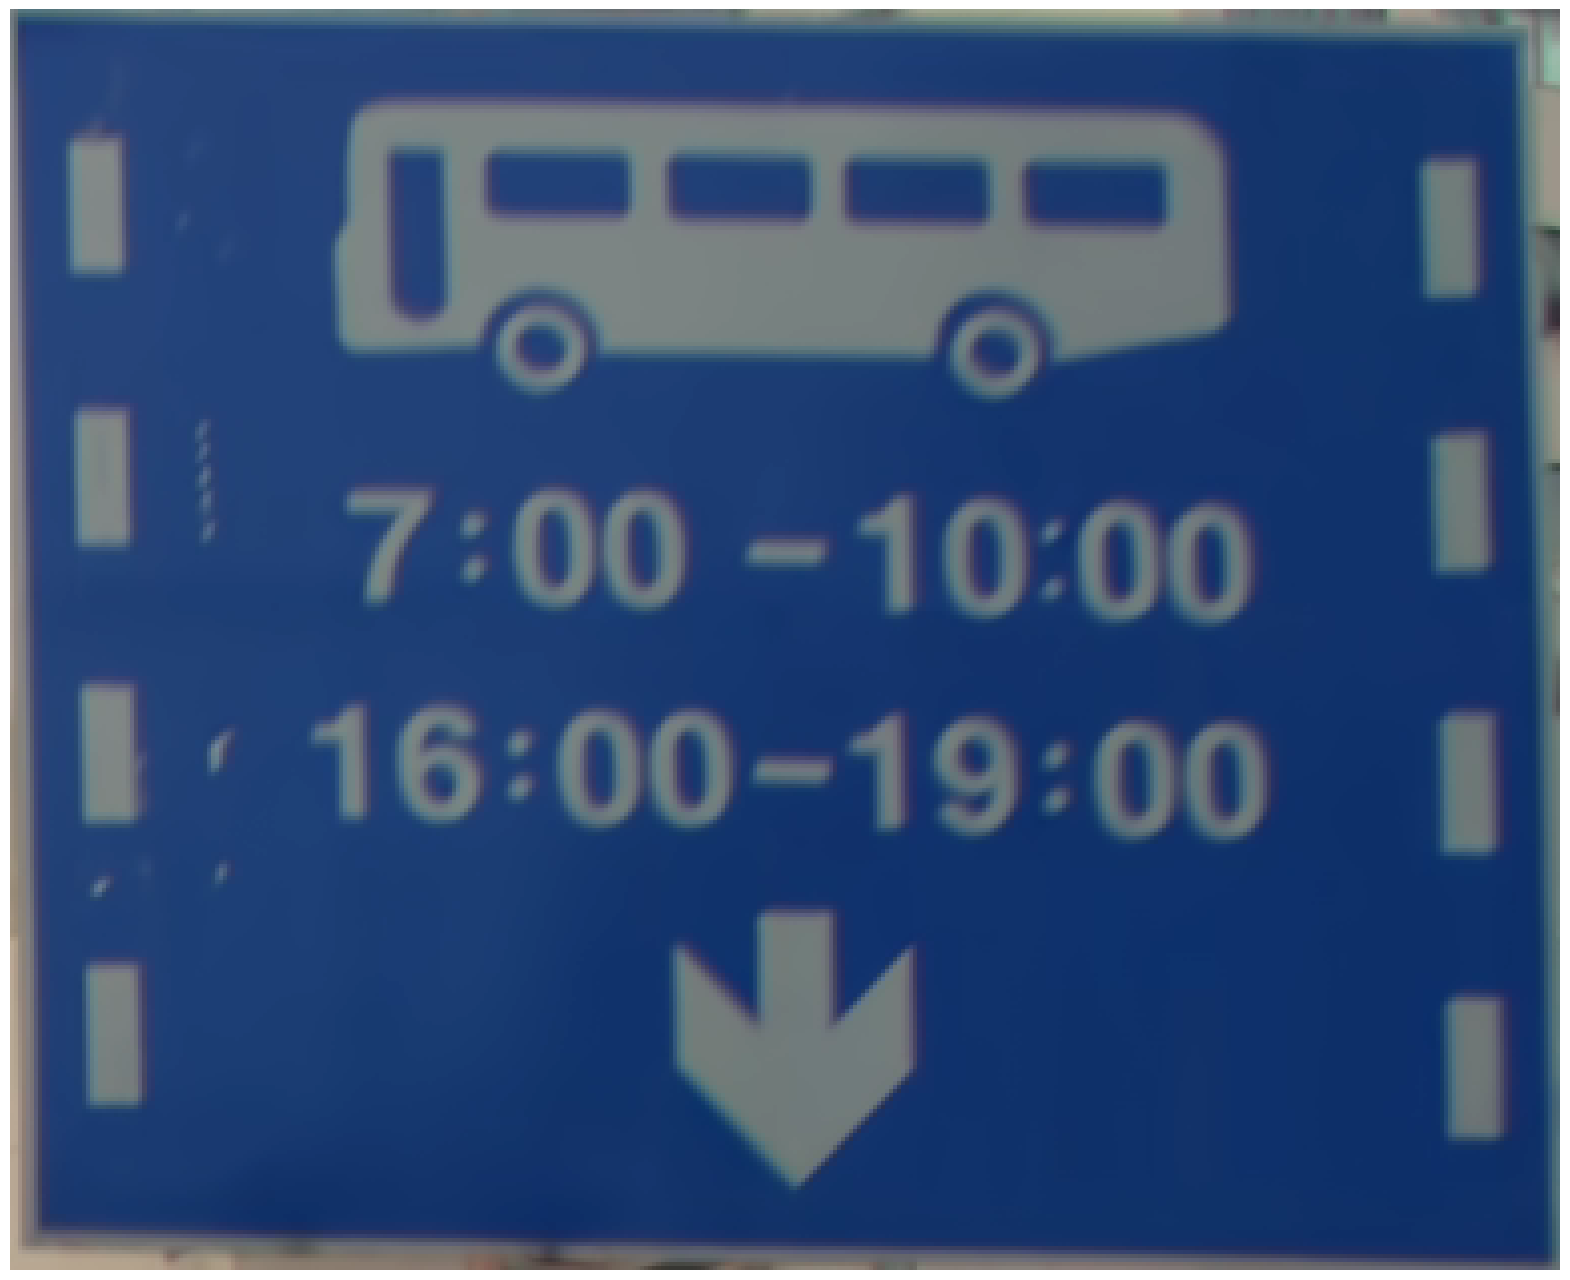

In [132]:
print(len(masks))
item_num = 0 #item_num為辨別出來之物體的編號（0=<item_num<(len(mask)))
print(masks[item_num].keys())
print(masks[item_num])

x = masks[item_num]['bbox'][0]
y = masks[item_num]['bbox'][1]
w = masks[item_num]['bbox'][2]
h = masks[item_num]['bbox'][3]


print(x,y,w,h)
crop_img = image[int(y):int(y)+h, int(x):x+w]
plt.figure(figsize=(20,20))
plt.imshow(crop_img)
plt.axis('off')
plt.show() 

In [133]:
from utils import solve_homography, warping
def transform(img, canvas, corners):
    """ 
    given a source image, a target canvas and the indicated corners, warp the source image to the target canvas
    :param img: input source image
    :param canvas: input canvas image
    :param corners: shape (4,2) numpy array, representing the four image corner (x, y) pairs
    :return: warped output image
    """
    h, w, ch = img.shape
    x = np.array([[0, 0],
                  [w, 0],
                  [w, h],
                  [0, h]
                  ])
    H = solve_homography(x, corners)
    
    
    return  warping(img, canvas, H, 0, h, 0, w, direction='f')

In [138]:
# ================== Part 1: Homography Estimation ========================
canvas = cv2.imread('../images/032.png')

# TODO: 1.you can use whatever images you like, include these images in the img directory
img = crop_img

canvas_corners1 = np.array([[2366, 364],[2366+355, 364], [2366+355,364+380], [2366, 364+380]])

# TODO: 2. implement the transform function
output1 = transform(crop_img, canvas, canvas_corners1)
cv2.imwrite('output1.png', output1)

True